# Assignment 5: Autonomous Driving (Part 3)

In this assignment, the goal is to try different configurations for the assignment Autonomous Driving (Part 2).


for learning to drive autonomously. For that reason, We will use the car racing example from [Gym](http://gym.openai.com). As we show in the last assignment, Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gym](http://gym.openai.com) in your system. The installation can be done with pip or by installing from the sources. More information at [https://gym.openai.com/docs/#installation](https://gym.openai.com/docs/#installation).

*Important*: The Python version of Gym and the Python version of PyTorch has to be the same. This is an important requirement for making the inference pipeline function.

Note that all scripts should be self-contained and executed on *any* machine that has required libraries installed.

The solutions of the assignment can be delivered as Python Notebooks or .py files. The visual results can delivered as pdf- or image-files.

**Deadline**: The assignment deadline is on 17.01.2020. 

## 1. Model Preparation

In this exercise, the trained model from the last assignment is necessary for performing different tests. The setups is the same where the car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels. The test set is the same from Assignment 2, i.e. 1000 test consecutive frames. The 1000 test samples also include a maneuver.
 
*Task Output*: Consider a model that is trained with the data augmentation from Assignment 2. Be sure that upside-down, left-right and street color augmentation are excluded during training. Test the model on the 1000 test frames for: 1. upside-down data flip, 2. left-right data flip and brown street color. You should generate three different videos (mp4) for each test scenario. On the first case all 1000 frames should flipped upside-down, on the second case all 1000 frames should flipped left-right and final on the last case the road should be painted brown for all 1000 frames. The deliverable of the exercise are the three videos.

*Important*: The scripts should be **self-contained**.

In [11]:
# import all necessary packages
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2
import os
from torchvision.transforms.functional import to_pil_image

In [12]:
#Function to load dataset

class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = np.load(images_file)
        self.labels = np.load(labels_file)
        self.labels = [convert_label(label) for label in self.labels]
        self.transform = transform
        if self.transform == horizontal_flip:
            self.labels = [hflip_label(label) for label in self.labels]



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]


        if self.transform is not None:
            transformed_image = self.transform(image)
        else:
            transformed_image = transforms.ToTensor()(image)

        
        return transformed_image, label

In [13]:
#Function to convert label
def convert_label(label):
    if np.array_equal(label, [0, 0, 0]):
        return 4 #do nothing
    elif np.array_equal(label, [0, 1, 0]):
        return 0 # forward
    elif np.array_equal(label, [-1, 0, 0]):
        return 1 # left
    elif np.array_equal(label, [1, 0, 0]):
        return 2 #right
    elif np.array_equal(label, [0, 0, 0.8]):
        return 3#stop

In [14]:
#Function to flip left and right if augmentaton applied is Horizontal Flip
def hflip_label(label):
    if label == 1:
        return 2
    elif label == 2:
        return 1
    else:
        return label

In [15]:
# Transform for horizontal flip
horizontal_flip = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.functional.hflip,  # Horizontal flip
    transforms.ToTensor()  # Convert PIL image to PyTorch tensor
])

# Vertical flip
vertical_flip = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.functional.vflip,  # Vertical flip
    transforms.ToTensor()  # Convert PIL image to PyTorch tensor
])

# brown street color
def brown_street(image):
    to_tensor = transforms.ToTensor()

    brown_rgb = np.array([150, 75, 0])
    gray_pixels = np.all(image == image[..., :1], axis=-1)
    image[gray_pixels] = brown_rgb
    # pil_image = Image.fromarray(image)

    tensor_image = to_tensor(image)

    return tensor_image


In [16]:
# Specify the file paths for images and labels
images_file = 'data/images.npy'
labels_file = 'data/labels.npy'

In [17]:
# Model used to train 
class Network(nn.Module):
    def __init__(self, final_node=False):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Sequential(
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # Adjust the number of output classes accordingly
        )

    def forward(self, x):
        x = x.squeeze(1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [18]:
#Load trained model from last assignment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TModel = Network()
TModel.to(device)
TModel.load_state_dict(torch.load('trained_model_weights.pth'))

<All keys matched successfully>

In [19]:
#Function to test model

def testModel(model, test_loader):
    model.eval() # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device) , labels.to(device)
            
            test = Variable(images.float())

            labels = Variable(labels)
            # Forward pass 
            outputs = model(test)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy: {} %'.format(100 * correct / total))

### TEST SCENARIO 1: LEFT-RIGHT FLIP

In [20]:
#Load Horizontally flipped dataset for testing
hflip_dataset = CustomDataset(images_file, labels_file, transform=horizontal_flip)
hflip_test = torch.utils.data.Subset(hflip_dataset, range(4000, 5000))
hflip_test_dataloader = DataLoader(hflip_test, batch_size=32, shuffle=False)
#Testing the model with horizontally flipped images
print('Testing horizontally flipped images')
testModel(TModel, hflip_test_dataloader)

Testing horizontally flipped images
Test Accuracy: 73.3 %


In [21]:
# Video of Horizontal Flip test set with corresponding labels
hflip_file = 'horizontal_test.avi'
fps = 10.0  # Frames per second
video_writer = cv2.VideoWriter(hflip_file, cv2.VideoWriter_fourcc(*'MJPG'), fps, (96, 96))

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

for i, image_index in enumerate(hflip_test.indices):
    image = hflip_dataset[image_index][0]  # Access the image tensor
    label = hflip_dataset[image_index][1]  # Access the label of the image

    # Convert the image tensor to PIL Image
    pil_image = to_pil_image(image)

    # Convert PIL Image to OpenCV-compatible format
    open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Add label text to the image
    label_text = str(label)
    label_position = (10, 20)  # Adjust the position of the label text
    cv2.putText(open_cv_image, label_text, label_position, font, font_scale, (255, 255, 255), font_thickness)

    # Write the frame to the video file
    video_writer.write(open_cv_image)

video_writer.release()

### TEST SCENARIO 2: UP-DOWN FLIP

In [22]:
#Load vertically flipped dataset for testing
vflip_dataset = CustomDataset(images_file, labels_file, transform=vertical_flip)
vflip_test = torch.utils.data.Subset(vflip_dataset, range(4000, 5000))
vflip_test_dataloader = DataLoader(vflip_test, batch_size=32, shuffle=False)
#Testing the model with vertically flipped images
print('Testing vertically flipped images')
testModel(TModel, vflip_test_dataloader)

Testing vertically flipped images
Test Accuracy: 53.1 %


In [23]:
# Video of vertically Flip test set with corresponding labels
vflip_file = 'vertical_test.avi'
fps = 10.0  # Frames per second
video_writer = cv2.VideoWriter(vflip_file, cv2.VideoWriter_fourcc(*'MJPG'), fps, (96, 96))

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

for i, image_index in enumerate(vflip_test.indices):
    image = vflip_dataset[image_index][0]  # Access the image tensor
    label = vflip_dataset[image_index][1]  # Access the label of the image

    # Convert the image tensor to PIL Image
    pil_image = to_pil_image(image)

    # Convert PIL Image to OpenCV-compatible format
    open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Add label text to the image
    label_text = str(label)
    label_position = (10, 20)  # Adjust the position of the label text
    cv2.putText(open_cv_image, label_text, label_position, font, font_scale, (255, 255, 255), font_thickness)

    # Write the frame to the video file
    video_writer.write(open_cv_image)

video_writer.release()

### TEST SCENARIO 3: BROWN STREET COLOR

In [24]:
#Load brown colored street dataset for testing
brown_dataset = CustomDataset(images_file, labels_file, transform=brown_street)
brown_test = torch.utils.data.Subset(brown_dataset, range(4000, 5000))
brown_test_dataloader = DataLoader(brown_test, batch_size=32, shuffle=False)
#Testing the model with brown colored street flipped images
print('Testing brown colored street flipped images')
testModel(TModel, brown_test_dataloader)

Testing brown colored street flipped images
Test Accuracy: 76.3 %


In [25]:
# Video of brown colored street Flip test set with corresponding labels
brown_file = 'brown_street_color_test.avi'
fps = 10.0  # Frames per second
video_writer = cv2.VideoWriter(brown_file, cv2.VideoWriter_fourcc(*'MJPG'), fps, (96, 96))

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

for i, image_index in enumerate(brown_test.indices):
    image = brown_dataset[image_index][0]  # Access the image tensor
    label = brown_dataset[image_index][1]  # Access the label of the image

    # Convert the image tensor to PIL Image
    pil_image = to_pil_image(image)

    # Convert PIL Image to OpenCV-compatible format
    open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Add label text to the image
    label_text = str(label)
    label_position = (10, 20)  # Adjust the position of the label text
    cv2.putText(open_cv_image, label_text, label_position, font, font_scale, (255, 255, 255), font_thickness)

    # Write the frame to the video file
    video_writer.write(open_cv_image)

video_writer.release()

## 2. Autonomous Driving

In this exercise, the trained model from the last assignment is necessary for end-to-end driving. The goal is to combine the simulator with the neural network where the neural network will take care of the control. For the reason, both programs have to executed under the same python script. The simulator will provide with input data the neural network, while the neural network will provide the control to the simulator.
 
*Task Output*: Consider a model that is trained with the data augmentation from Assignment 2. Integrate the simulator in the inference script of the model. The output of the exercise is to launch the simulator and let the neural network perform the driving. This should be a live demo.

*Important*: The scripts should be **self-contained**.

In [26]:
import matplotlib.pyplot as plt
import math
from typing import Optional, Union
import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.box2d.car_dynamics import Car
from gymnasium.error import DependencyNotInstalled, InvalidAction
from gymnasium.utils import EzPickle
import os

try:
    import Box2D
    from Box2D.b2 import contactListener, fixtureDef, polygonShape
except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e

try:
    # As pygame is necessary for using the environment (reset and step) even without a render mode
    #   therefore, pygame is a necessary import for the environment.
    import pygame
    from pygame import gfxdraw
except ImportError as e:
    raise DependencyNotInstalled(
        "pygame is not installed, run `pip install gymnasium[box2d]`"
    ) from e

STATE_W = 96  # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE = 6.0  # Track scale
TRACK_RAD = 900 / SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD = 2000 / SCALE  # Game over boundary
FPS = 50  # Frames per second
ZOOM = 2.7  # Camera zoom
ZOOM_FOLLOW = True  # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21 / SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40 / SCALE
BORDER = 8 / SCALE
BORDER_MIN_COUNT = 4
GRASS_DIM = PLAYFIELD / 20.0
MAX_SHAPE_DIM = (
    max(GRASS_DIM, TRACK_WIDTH, TRACK_DETAIL_STEP) * math.sqrt(2) * ZOOM * SCALE
)

class FrictionDetector(contactListener):
    def __init__(self, env, lap_complete_percent):
        contactListener.__init__(self)
        self.env = env
        self.lap_complete_percent = lap_complete_percent

    def BeginContact(self, contact):
        self._contact(contact, True)

    def EndContact(self, contact):
        self._contact(contact, False)

    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj = u1
        if not tile:
            return

        # inherit tile color from env
        tile.color[:] = self.env.road_color
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0 / len(self.env.track)
                self.env.tile_visited_count += 1

                # Lap is considered completed if enough % of the track was covered
                if (
                    tile.idx == 0
                    and self.env.tile_visited_count / len(self.env.track)
                    > self.lap_complete_percent
                ):
                    self.env.new_lap = True
        else:
            obj.tiles.remove(tile)


class CarRacing(gym.Env, EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "state_pixels",
        ],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        verbose: bool = False,
        lap_complete_percent: float = 0.95,
        domain_randomize: bool = False,
        continuous: bool = True,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            verbose,
            lap_complete_percent,
            domain_randomize,
            continuous,
        )
        self.continuous = continuous
        self.domain_randomize = domain_randomize
        self.lap_complete_percent = lap_complete_percent
        self._init_colors()

        self.contactListener_keepref = FrictionDetector(self, self.lap_complete_percent)
        self.world = Box2D.b2World((0, 0), contactListener=self.contactListener_keepref)
        self.screen: Optional[pygame.Surface] = None
        self.surf = None
        self.clock = None
        self.isopen = True
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car: Optional[Car] = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.new_lap = False
        self.fd_tile = fixtureDef(
            shape=polygonShape(vertices=[(0, 0), (1, 0), (1, -1), (0, -1)])
        )

        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised however this is not possible here so ignore
        if self.continuous:
            self.action_space = spaces.Box(
                np.array([-1, 0, 0]).astype(np.float32),
                np.array([+1, +1, +1]).astype(np.float32),
            )  # steer, gas, brake
        else:
            self.action_space = spaces.Discrete(5)
            # do nothing, left, right, gas, brake

        self.observation_space = spaces.Box(
            low=0, high=255, shape=(STATE_H, STATE_W, 3), dtype=np.uint8
        )

        self.render_mode = render_mode

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        assert self.car is not None
        self.car.destroy()

    def _init_colors(self):
        if self.domain_randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20
        else:
            # default colours
            self.road_color = np.array([102, 102, 102])
            self.bg_color = np.array([102, 204, 102])
            self.grass_color = np.array([102, 230, 102])

    def _reinit_colors(self, randomize):
        assert (
            self.domain_randomize
        ), "domain_randomize must be True to use this function."

        if randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            noise = self.np_random.uniform(0, 2 * math.pi * 1 / CHECKPOINTS)
            alpha = 2 * math.pi * c / CHECKPOINTS + noise
            rad = self.np_random.uniform(TRACK_RAD / 3, TRACK_RAD)

            if c == 0:
                alpha = 0
                rad = 1.5 * TRACK_RAD
            if c == CHECKPOINTS - 1:
                alpha = 2 * math.pi * c / CHECKPOINTS
                self.start_alpha = 2 * math.pi * (-0.5) / CHECKPOINTS
                rad = 1.5 * TRACK_RAD

            checkpoints.append((alpha, rad * math.cos(alpha), rad * math.sin(alpha)))
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5 * TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2 * math.pi

            while True:  # Find destination from checkpoints
                failed = True

                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break

                if not failed:
                    break

                alpha -= 2 * math.pi
                continue

            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            # destination vector projected on rad:
            proj = r1x * dest_dx + r1y * dest_dy
            while beta - alpha > 1.5 * math.pi:
                beta -= 2 * math.pi
            while beta - alpha < -1.5 * math.pi:
                beta += 2 * math.pi
            prev_beta = beta
            proj *= SCALE
            if proj > 0.3:
                beta -= min(TRACK_TURN_RATE, abs(0.001 * proj))
            if proj < -0.3:
                beta += min(TRACK_TURN_RATE, abs(0.001 * proj))
            x += p1x * TRACK_DETAIL_STEP
            y += p1y * TRACK_DETAIL_STEP
            track.append((alpha, prev_beta * 0.5 + beta * 0.5, x, y))
            if laps > 4:
                break
            no_freeze -= 1
            if no_freeze == 0:
                break

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i == 0:
                return False  # Failed
            pass_through_start = (
                track[i][0] > self.start_alpha and track[i - 1][0] <= self.start_alpha
            )
            if pass_through_start and i2 == -1:
                i2 = i
            elif pass_through_start and i1 == -1:
                i1 = i
                break
        if self.verbose:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2 - i1))
        assert i1 != -1
        assert i2 != -1

        track = track[i1 : i2 - 1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square(first_perp_x * (track[0][2] - track[-1][2]))
            + np.square(first_perp_y * (track[0][3] - track[-1][3]))
        )
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False] * len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i - neg - 0][1]
                beta2 = track[i - neg - 1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE * 0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i - neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i - 1]
            road1_l = (
                x1 - TRACK_WIDTH * math.cos(beta1),
                y1 - TRACK_WIDTH * math.sin(beta1),
            )
            road1_r = (
                x1 + TRACK_WIDTH * math.cos(beta1),
                y1 + TRACK_WIDTH * math.sin(beta1),
            )
            road2_l = (
                x2 - TRACK_WIDTH * math.cos(beta2),
                y2 - TRACK_WIDTH * math.sin(beta2),
            )
            road2_r = (
                x2 + TRACK_WIDTH * math.cos(beta2),
                y2 + TRACK_WIDTH * math.sin(beta2),
            )
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01 * (i % 3) * 255
            t.color = self.road_color + c
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road_poly.append(([road1_l, road1_r, road2_r, road2_l], t.color))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (
                    x1 + side * TRACK_WIDTH * math.cos(beta1),
                    y1 + side * TRACK_WIDTH * math.sin(beta1),
                )
                b1_r = (
                    x1 + side * (TRACK_WIDTH + BORDER) * math.cos(beta1),
                    y1 + side * (TRACK_WIDTH + BORDER) * math.sin(beta1),
                )
                b2_l = (
                    x2 + side * TRACK_WIDTH * math.cos(beta2),
                    y2 + side * TRACK_WIDTH * math.sin(beta2),
                )
                b2_r = (
                    x2 + side * (TRACK_WIDTH + BORDER) * math.cos(beta2),
                    y2 + side * (TRACK_WIDTH + BORDER) * math.sin(beta2),
                )
                self.road_poly.append(
                    (
                        [b1_l, b1_r, b2_r, b2_l],
                        (255, 255, 255) if i % 2 == 0 else (255, 0, 0),
                    )
                )
        self.track = track
        return True

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_bug_workaround = FrictionDetector(
            self, self.lap_complete_percent
        )
        self.world.contactListener = self.world.contactListener_bug_workaround
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.new_lap = False
        self.road_poly = []

        if self.domain_randomize:
            randomize = True
            if isinstance(options, dict):
                if "randomize" in options:
                    randomize = options["randomize"]

            self._reinit_colors(randomize)

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose:
                print(
                    "retry to generate track (normal if there are not many"
                    "instances of this message)"
                )
        self.car = Car(self.world, *self.track[0][1:4])

        if self.render_mode == "human":
            self.render()
            
            
        return self.step(None)[0], {}

    def step(self, action: Union[np.ndarray, int]):
        assert self.car is not None
        if action is not None:
            if self.continuous:
                self.car.steer(-action[0])
                self.car.gas(action[1])
                self.car.brake(action[2])
            else:
                if not self.action_space.contains(action):
                    raise InvalidAction(
                        f"you passed the invalid action `{action}`. "
                        f"The supported action_space is `{self.action_space}`"
                    )
                self.car.steer(-0.6 * (action == 1) + 0.6 * (action == 2))
                self.car.gas(0.2 * (action == 3))
                self.car.brake(0.8 * (action == 4))

        self.car.step(1.0 / FPS)
        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)
        self.t += 1.0 / FPS

        self.state = self._render("state_pixels")

        step_reward = 0
        terminated = False
        truncated = False
        if action is not None:  # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count == len(self.track) or self.new_lap:
                # Truncation due to finishing lap
                # This should not be treated as a failure
                # but like a timeout
                truncated = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                terminated = True
                step_reward = -100

        if self.render_mode == "human":
            self.render()
            
        return self.state, step_reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        else:
            return self._render(self.render_mode)

    def _render(self, mode: str):
        assert mode in self.metadata["render_modes"]

        pygame.font.init()
        if self.screen is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((WINDOW_W, WINDOW_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if "t" not in self.__dict__:
            return  # reset() not called yet

        self.surf = pygame.Surface((WINDOW_W, WINDOW_H))

        assert self.car is not None
        # computing transformations
        angle = -self.car.hull.angle
        # Animating first second zoom.
        zoom = 0.1 * SCALE * max(1 - self.t, 0) + ZOOM * SCALE * min(self.t, 1)
        scroll_x = -(self.car.hull.position[0]) * zoom
        scroll_y = -(self.car.hull.position[1]) * zoom
        trans = pygame.math.Vector2((scroll_x, scroll_y)).rotate_rad(angle)
        trans = (WINDOW_W / 2 + trans[0], WINDOW_H / 4 + trans[1])

        self._render_road(zoom, trans, angle)
        self.car.draw(
            self.surf,
            zoom,
            trans,
            angle,
            mode not in ["state_pixels_list", "state_pixels"],
        )

        self.surf = pygame.transform.flip(self.surf, False, True)

        # showing stats
        self._render_indicators(WINDOW_W, WINDOW_H)

        font = pygame.font.Font(pygame.font.get_default_font(), 42)
        text = font.render("%04i" % self.reward, True, (255, 255, 255), (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (60, WINDOW_H - WINDOW_H * 2.5 / 40.0)
        self.surf.blit(text, text_rect)

        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            assert self.screen is not None
            self.screen.fill(0)
            self.screen.blit(self.surf, (0, 0))
            pygame.display.flip()
        elif mode == "rgb_array":
            return self._create_image_array(self.surf, (VIDEO_W, VIDEO_H))
        elif mode == "state_pixels":
            return self._create_image_array(self.surf, (STATE_W, STATE_H))
        else:
            return self.isopen

    def _render_road(self, zoom, translation, angle):
        bounds = PLAYFIELD
        field = [
            (bounds, bounds),
            (bounds, -bounds),
            (-bounds, -bounds),
            (-bounds, bounds),
        ]

        # draw background
        self._draw_colored_polygon(
            self.surf, field, self.bg_color, zoom, translation, angle, clip=False
        )

        # draw grass patches
        grass = []
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                grass.append(
                    [
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + GRASS_DIM),
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + GRASS_DIM),
                    ]
                )
        for poly in grass:
            self._draw_colored_polygon(
                self.surf, poly, self.grass_color, zoom, translation, angle
            )

        # draw road
        for poly, color in self.road_poly:
            # converting to pixel coordinates
            poly = [(p[0], p[1]) for p in poly]
            color = [int(c) for c in color]
            self._draw_colored_polygon(self.surf, poly, color, zoom, translation, angle)

    def _render_indicators(self, W, H):
        s = W / 40.0
        h = H / 40.0
        color = (0, 0, 0)
        polygon = [(W, H), (W, H - 5 * h), (0, H - 5 * h), (0, H)]
        pygame.draw.polygon(self.surf, color=color, points=polygon)

        def vertical_ind(place, val):
            return [
                (place * s, H - (h + h * val)),
                ((place + 1) * s, H - (h + h * val)),
                ((place + 1) * s, H - h),
                ((place + 0) * s, H - h),
            ]

        def horiz_ind(place, val):
            return [
                ((place + 0) * s, H - 4 * h),
                ((place + val) * s, H - 4 * h),
                ((place + val) * s, H - 2 * h),
                ((place + 0) * s, H - 2 * h),
            ]

        assert self.car is not None
        true_speed = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )

        # simple wrapper to render if the indicator value is above a threshold
        def render_if_min(value, points, color):
            if abs(value) > 1e-4:
                pygame.draw.polygon(self.surf, points=points, color=color)

        render_if_min(true_speed, vertical_ind(5, 0.02 * true_speed), (255, 255, 255))
        # ABS sensors
        render_if_min(
            self.car.wheels[0].omega,
            vertical_ind(7, 0.01 * self.car.wheels[0].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[1].omega,
            vertical_ind(8, 0.01 * self.car.wheels[1].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[2].omega,
            vertical_ind(9, 0.01 * self.car.wheels[2].omega),
            (51, 0, 255),
        )
        render_if_min(
            self.car.wheels[3].omega,
            vertical_ind(10, 0.01 * self.car.wheels[3].omega),
            (51, 0, 255),
        )

        render_if_min(
            self.car.wheels[0].joint.angle,
            horiz_ind(20, -10.0 * self.car.wheels[0].joint.angle),
            (0, 255, 0),
        )
        render_if_min(
            self.car.hull.angularVelocity,
            horiz_ind(30, -0.8 * self.car.hull.angularVelocity),
            (255, 0, 0),
        )

    def _draw_colored_polygon(
        self, surface, poly, color, zoom, translation, angle, clip=True
    ):
        poly = [pygame.math.Vector2(c).rotate_rad(angle) for c in poly]
        poly = [
            (c[0] * zoom + translation[0], c[1] * zoom + translation[1]) for c in poly
        ]
        # This checks if the polygon is out of bounds of the screen, and we skip drawing if so.
        # Instead of calculating exactly if the polygon and screen overlap,
        # we simply check if the polygon is in a larger bounding box whose dimension
        # is greater than the screen by MAX_SHAPE_DIM, which is the maximum
        # diagonal length of an environment object
        if not clip or any(
            (-MAX_SHAPE_DIM <= coord[0] <= WINDOW_W + MAX_SHAPE_DIM)
            and (-MAX_SHAPE_DIM <= coord[1] <= WINDOW_H + MAX_SHAPE_DIM)
            for coord in poly
        ):
            gfxdraw.aapolygon(self.surf, poly, color)
            gfxdraw.filled_polygon(self.surf, poly, color)

    def _create_image_array(self, screen, size):
        scaled_screen = pygame.transform.smoothscale(screen, size)
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(scaled_screen)), axes=(1, 0, 2)
        )

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            self.isopen = False
            pygame.quit()


if __name__ == "__main__":
    a = np.array([0.0, 0.0, 0.0])

    def register_input():
        global quit
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    quit = True

    TrainedModel = Network()
    TrainedModel.load_state_dict(torch.load('trained_model_weights.pth'))
    
    env = CarRacing(render_mode="human")

    quit = False
    while not quit:
        env.reset()
        total_reward = 0.0
        restart = False
        state, r, terminated, truncated, info = env.step(a)
        
        annotation_reverse_mapping = {
            4: (0, 0, 0),
            0: (0, 1, 0),  # accel
            1: (-1, 0, 0),  # turn left
            2: (1, 0, 0),   # turn right
            3: (0, 0, 0.5), #reverse
            
        }
        
        while True:
            register_input()
            image_tensor = torch.from_numpy(state.transpose((2, 0, 1))).unsqueeze(0).float() / 255.0
            output = TrainedModel(image_tensor)
            predicted_label = torch.argmax(torch.softmax(output, dim=1), dim=1)
            if predicted_label.item() in annotation_reverse_mapping:
                action = np.array(annotation_reverse_mapping[predicted_label.item()])

            total_reward += r
            
            state, r, terminated, truncated, info = env.step(action)
            
            if terminated or truncated or restart or quit:
                break

    env.close()

## 3. Recurrent Neural Network Model

In this task, the goal is to change the feed forward network with the recurrent neural network that makes use of temporal information. Instead of training a model that works with a single input image, we will train a model the receives multiple input frames to make a decision. As a result, the proposed model can be seen as multiple input to multiple output. During training, the number of input images can be fixed though.

 
*Task Output*: The feed forward network should be replaced with a recurrent neural network (RNN). The number of cells can be freely chosen. Once the RNN is trained, it should be used for end-to-end driving as in the previous exercise. The output of the exercise is to launch the simulator and let the RNN perform the driving. This should be a live demo as well.

*Important*: The scripts should be **self-contained**.

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2
import os
from torchvision.transforms.functional import to_pil_image

In [2]:
#Function to load dataset
class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = np.load(images_file)
        self.labels = np.load(labels_file)
        self.labels = [convert_label(label) for label in self.labels]
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]


        if self.transform is not None:
            transformed_image = self.transform(image)
        else:
            transformed_image = transforms.ToTensor()(image)

        
        return transformed_image, label

In [3]:
#convert label
def convert_label(label):
    if np.array_equal(label, [0, 0, 0]):
        return 4 #do nothing
    elif np.array_equal(label, [0, 1, 0]):
        return 0 # forward
    elif np.array_equal(label, [-1, 0, 0]):
        return 1 # left
    elif np.array_equal(label, [1, 0, 0]):
        return 2 #right
    elif np.array_equal(label, [0, 0, 0.8]):
        return 3#decelerate

# Specify the file paths for images and labels
images_file = 'data/images.npy'
labels_file = 'data/labels.npy'

In [4]:
#RNN Model
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.rnn = nn.RNN(input_size=128 * 12 * 12, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # Adjust the number of output classes accordingly
        )

    def forward(self, x):
        x = x.squeeze(1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        # Pass through the RNN layer
        x = x.unsqueeze(1)  # Add a time step dimension
        _, x = self.rnn(x)
        x = x[-1]
        # x = x.squeeze(0)  # Remove the time step dimension

        
        x = self.fc(x)

        return x

In [5]:
#Function to train
def DeepLearner(model, train_data,val_data):

    error = nn.CrossEntropyLoss()

    
    
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create the SGD optimizer
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Train

    num_epochs = 30
    count = 0
    # Lists for visualization of loss and accuracy 
    loss_list = []
    iteration_list = []
    accuracy_list = []

    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_data:
            # Transfering images and labels to GPU if available
            images, labels= images.to(device) , labels.to(device)
            train = Variable(images.float())

            labels = Variable(labels)

            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels.long())

            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()

            #Propagating the error backward
            loss.backward()

            # Optimizing the parameters
            optimizer.step()

            count += 1

        # Validating the model
            
            if not (count % 10):
                model.eval()
                total = 0
                correct = 0
                with torch.no_grad():
                    
                    for images, labels in val_data:
                        images, labels= images.to(device) , labels.to(device)
                        labels_list.append(labels)

                        val = Variable(images.float())

                        outputs = model(val)

                        predictions = torch.max((outputs), 1)[1].to(device)
                        predictions_list.append(predictions)
                        correct += (predictions == labels).sum()

                        total += len(labels)

                    accuracy = correct * 100 / total
                    loss_list.append(loss.item())
                    iteration_list.append(count)
                    accuracy_list.append(accuracy.item())

                if not (count % 100):
                    print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
                model.train()
                
    torch.save(model.state_dict(), 'rnn_trained_model_weights.pth')            
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss")

    plt.subplot(1, 2, 2)
    plt.plot(iteration_list, accuracy_list)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.show()

In [6]:
#Function to test
def testModel(model, test_loader):
    model.eval() # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device) , labels.to(device)
            
            test = Variable(images.float())

            labels = Variable(labels)
            # Forward pass 
            outputs = model(test)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy: {} %'.format(100 * correct / total))

In [7]:
#Tansform to augment data

def transform_train(image):
    to_tensor = transforms.ToTensor()
    rotation = transforms.RandomRotation(degrees=20)
    pil_image = Image.fromarray(image)

    cropped_image = pil_image.crop((0, 0, 96, 84))
    resized_image = cropped_image.resize((96, 96))

    rotated_image = rotation(resized_image)
    tensor_image = to_tensor(rotated_image)

    return tensor_image

In [8]:
dataset = CustomDataset(images_file, labels_file, transform=transform_train)


train_subset = torch.utils.data.Subset(dataset, range(0, 3000))
val_subset = torch.utils.data.Subset(dataset, range(3000, 4000))
test_subset = torch.utils.data.Subset(dataset, range(4000, 5000))


train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=32, shuffle=False)

Iteration: 100, Loss: 1.1722733974456787, Accuracy: 47.10000228881836%
Iteration: 200, Loss: 0.5282512307167053, Accuracy: 71.80000305175781%
Iteration: 300, Loss: 0.5053784847259521, Accuracy: 63.80000305175781%
Iteration: 400, Loss: 0.1458449363708496, Accuracy: 78.60000610351562%
Iteration: 500, Loss: 1.272151231765747, Accuracy: 79.80000305175781%
Iteration: 600, Loss: 0.6059259176254272, Accuracy: 78.70000457763672%
Iteration: 700, Loss: 0.8131252527236938, Accuracy: 79.5%
Iteration: 800, Loss: 0.6809635758399963, Accuracy: 81.80000305175781%
Iteration: 900, Loss: 0.7694754600524902, Accuracy: 79.30000305175781%
Iteration: 1000, Loss: 0.9617250561714172, Accuracy: 80.9000015258789%
Iteration: 1100, Loss: 0.7460792660713196, Accuracy: 80.50000762939453%
Iteration: 1200, Loss: 0.6430509090423584, Accuracy: 79.4000015258789%
Iteration: 1300, Loss: 0.6792736649513245, Accuracy: 80.30000305175781%
Iteration: 1400, Loss: 0.23621012270450592, Accuracy: 79.0%
Iteration: 1500, Loss: 0.3053

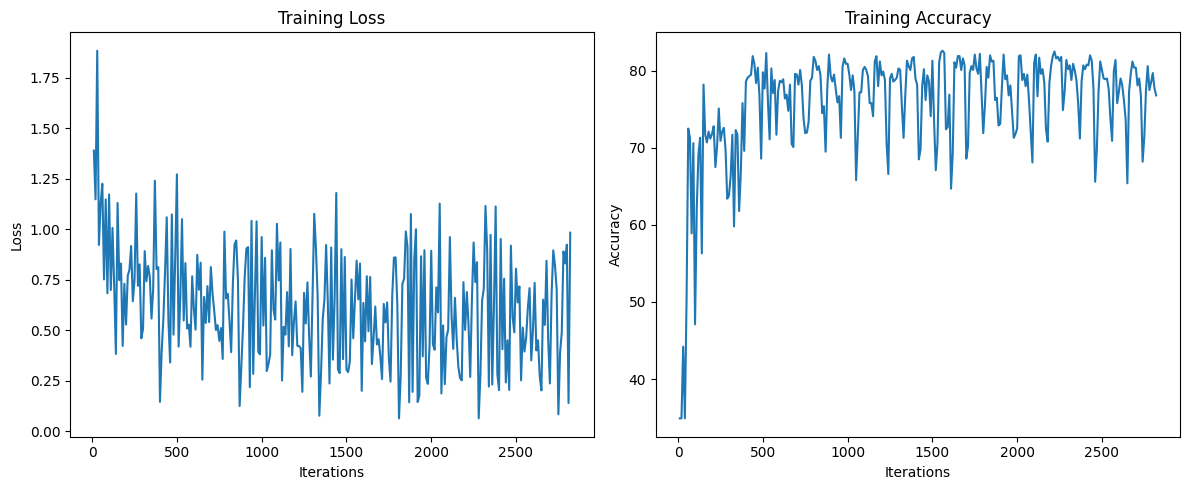

Test Accuracy: 75.9 %


In [9]:
# Training RNN model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


RNNModel = Network()
RNNModel.to(device)

DeepLearner(RNNModel, train_dataloader,val_dataloader)
testModel(RNNModel, test_dataloader)

In [10]:
import matplotlib.pyplot as plt
import math
from typing import Optional, Union
import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.box2d.car_dynamics import Car
from gymnasium.error import DependencyNotInstalled, InvalidAction
from gymnasium.utils import EzPickle
import os

try:
    import Box2D
    from Box2D.b2 import contactListener, fixtureDef, polygonShape
except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e

try:
    # As pygame is necessary for using the environment (reset and step) even without a render mode
    #   therefore, pygame is a necessary import for the environment.
    import pygame
    from pygame import gfxdraw
except ImportError as e:
    raise DependencyNotInstalled(
        "pygame is not installed, run `pip install gymnasium[box2d]`"
    ) from e

STATE_W = 96  # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE = 6.0  # Track scale
TRACK_RAD = 900 / SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD = 2000 / SCALE  # Game over boundary
FPS = 50  # Frames per second
ZOOM = 2.7  # Camera zoom
ZOOM_FOLLOW = True  # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21 / SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40 / SCALE
BORDER = 8 / SCALE
BORDER_MIN_COUNT = 4
GRASS_DIM = PLAYFIELD / 20.0
MAX_SHAPE_DIM = (
    max(GRASS_DIM, TRACK_WIDTH, TRACK_DETAIL_STEP) * math.sqrt(2) * ZOOM * SCALE
)

class FrictionDetector(contactListener):
    def __init__(self, env, lap_complete_percent):
        contactListener.__init__(self)
        self.env = env
        self.lap_complete_percent = lap_complete_percent

    def BeginContact(self, contact):
        self._contact(contact, True)

    def EndContact(self, contact):
        self._contact(contact, False)

    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj = u1
        if not tile:
            return

        # inherit tile color from env
        tile.color[:] = self.env.road_color
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0 / len(self.env.track)
                self.env.tile_visited_count += 1

                # Lap is considered completed if enough % of the track was covered
                if (
                    tile.idx == 0
                    and self.env.tile_visited_count / len(self.env.track)
                    > self.lap_complete_percent
                ):
                    self.env.new_lap = True
        else:
            obj.tiles.remove(tile)


class CarRacing(gym.Env, EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "state_pixels",
        ],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        verbose: bool = False,
        lap_complete_percent: float = 0.95,
        domain_randomize: bool = False,
        continuous: bool = True,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            verbose,
            lap_complete_percent,
            domain_randomize,
            continuous,
        )
        self.continuous = continuous
        self.domain_randomize = domain_randomize
        self.lap_complete_percent = lap_complete_percent
        self._init_colors()

        self.contactListener_keepref = FrictionDetector(self, self.lap_complete_percent)
        self.world = Box2D.b2World((0, 0), contactListener=self.contactListener_keepref)
        self.screen: Optional[pygame.Surface] = None
        self.surf = None
        self.clock = None
        self.isopen = True
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car: Optional[Car] = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.new_lap = False
        self.fd_tile = fixtureDef(
            shape=polygonShape(vertices=[(0, 0), (1, 0), (1, -1), (0, -1)])
        )

        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised however this is not possible here so ignore
        if self.continuous:
            self.action_space = spaces.Box(
                np.array([-1, 0, 0]).astype(np.float32),
                np.array([+1, +1, +1]).astype(np.float32),
            )  # steer, gas, brake
        else:
            self.action_space = spaces.Discrete(5)
            # do nothing, left, right, gas, brake

        self.observation_space = spaces.Box(
            low=0, high=255, shape=(STATE_H, STATE_W, 3), dtype=np.uint8
        )

        self.render_mode = render_mode

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        assert self.car is not None
        self.car.destroy()

    def _init_colors(self):
        if self.domain_randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20
        else:
            # default colours
            self.road_color = np.array([102, 102, 102])
            self.bg_color = np.array([102, 204, 102])
            self.grass_color = np.array([102, 230, 102])

    def _reinit_colors(self, randomize):
        assert (
            self.domain_randomize
        ), "domain_randomize must be True to use this function."

        if randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            noise = self.np_random.uniform(0, 2 * math.pi * 1 / CHECKPOINTS)
            alpha = 2 * math.pi * c / CHECKPOINTS + noise
            rad = self.np_random.uniform(TRACK_RAD / 3, TRACK_RAD)

            if c == 0:
                alpha = 0
                rad = 1.5 * TRACK_RAD
            if c == CHECKPOINTS - 1:
                alpha = 2 * math.pi * c / CHECKPOINTS
                self.start_alpha = 2 * math.pi * (-0.5) / CHECKPOINTS
                rad = 1.5 * TRACK_RAD

            checkpoints.append((alpha, rad * math.cos(alpha), rad * math.sin(alpha)))
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5 * TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2 * math.pi

            while True:  # Find destination from checkpoints
                failed = True

                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break

                if not failed:
                    break

                alpha -= 2 * math.pi
                continue

            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            # destination vector projected on rad:
            proj = r1x * dest_dx + r1y * dest_dy
            while beta - alpha > 1.5 * math.pi:
                beta -= 2 * math.pi
            while beta - alpha < -1.5 * math.pi:
                beta += 2 * math.pi
            prev_beta = beta
            proj *= SCALE
            if proj > 0.3:
                beta -= min(TRACK_TURN_RATE, abs(0.001 * proj))
            if proj < -0.3:
                beta += min(TRACK_TURN_RATE, abs(0.001 * proj))
            x += p1x * TRACK_DETAIL_STEP
            y += p1y * TRACK_DETAIL_STEP
            track.append((alpha, prev_beta * 0.5 + beta * 0.5, x, y))
            if laps > 4:
                break
            no_freeze -= 1
            if no_freeze == 0:
                break

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i == 0:
                return False  # Failed
            pass_through_start = (
                track[i][0] > self.start_alpha and track[i - 1][0] <= self.start_alpha
            )
            if pass_through_start and i2 == -1:
                i2 = i
            elif pass_through_start and i1 == -1:
                i1 = i
                break
        if self.verbose:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2 - i1))
        assert i1 != -1
        assert i2 != -1

        track = track[i1 : i2 - 1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square(first_perp_x * (track[0][2] - track[-1][2]))
            + np.square(first_perp_y * (track[0][3] - track[-1][3]))
        )
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False] * len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i - neg - 0][1]
                beta2 = track[i - neg - 1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE * 0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i - neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i - 1]
            road1_l = (
                x1 - TRACK_WIDTH * math.cos(beta1),
                y1 - TRACK_WIDTH * math.sin(beta1),
            )
            road1_r = (
                x1 + TRACK_WIDTH * math.cos(beta1),
                y1 + TRACK_WIDTH * math.sin(beta1),
            )
            road2_l = (
                x2 - TRACK_WIDTH * math.cos(beta2),
                y2 - TRACK_WIDTH * math.sin(beta2),
            )
            road2_r = (
                x2 + TRACK_WIDTH * math.cos(beta2),
                y2 + TRACK_WIDTH * math.sin(beta2),
            )
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01 * (i % 3) * 255
            t.color = self.road_color + c
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road_poly.append(([road1_l, road1_r, road2_r, road2_l], t.color))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (
                    x1 + side * TRACK_WIDTH * math.cos(beta1),
                    y1 + side * TRACK_WIDTH * math.sin(beta1),
                )
                b1_r = (
                    x1 + side * (TRACK_WIDTH + BORDER) * math.cos(beta1),
                    y1 + side * (TRACK_WIDTH + BORDER) * math.sin(beta1),
                )
                b2_l = (
                    x2 + side * TRACK_WIDTH * math.cos(beta2),
                    y2 + side * TRACK_WIDTH * math.sin(beta2),
                )
                b2_r = (
                    x2 + side * (TRACK_WIDTH + BORDER) * math.cos(beta2),
                    y2 + side * (TRACK_WIDTH + BORDER) * math.sin(beta2),
                )
                self.road_poly.append(
                    (
                        [b1_l, b1_r, b2_r, b2_l],
                        (255, 255, 255) if i % 2 == 0 else (255, 0, 0),
                    )
                )
        self.track = track
        return True

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_bug_workaround = FrictionDetector(
            self, self.lap_complete_percent
        )
        self.world.contactListener = self.world.contactListener_bug_workaround
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.new_lap = False
        self.road_poly = []

        if self.domain_randomize:
            randomize = True
            if isinstance(options, dict):
                if "randomize" in options:
                    randomize = options["randomize"]

            self._reinit_colors(randomize)

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose:
                print(
                    "retry to generate track (normal if there are not many"
                    "instances of this message)"
                )
        self.car = Car(self.world, *self.track[0][1:4])

        if self.render_mode == "human":
            self.render()
            
            
        return self.step(None)[0], {}

    def step(self, action: Union[np.ndarray, int]):
        assert self.car is not None
        if action is not None:
            if self.continuous:
                self.car.steer(-action[0])
                self.car.gas(action[1])
                self.car.brake(action[2])
            else:
                if not self.action_space.contains(action):
                    raise InvalidAction(
                        f"you passed the invalid action `{action}`. "
                        f"The supported action_space is `{self.action_space}`"
                    )
                self.car.steer(-0.6 * (action == 1) + 0.6 * (action == 2))
                self.car.gas(0.2 * (action == 3))
                self.car.brake(0.8 * (action == 4))

        self.car.step(1.0 / FPS)
        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)
        self.t += 1.0 / FPS

        self.state = self._render("state_pixels")

        step_reward = 0
        terminated = False
        truncated = False
        if action is not None:  # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count == len(self.track) or self.new_lap:
                # Truncation due to finishing lap
                # This should not be treated as a failure
                # but like a timeout
                truncated = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                terminated = True
                step_reward = -100

        if self.render_mode == "human":
            self.render()
            
        return self.state, step_reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        else:
            return self._render(self.render_mode)

    def _render(self, mode: str):
        assert mode in self.metadata["render_modes"]

        pygame.font.init()
        if self.screen is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((WINDOW_W, WINDOW_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if "t" not in self.__dict__:
            return  # reset() not called yet

        self.surf = pygame.Surface((WINDOW_W, WINDOW_H))

        assert self.car is not None
        # computing transformations
        angle = -self.car.hull.angle
        # Animating first second zoom.
        zoom = 0.1 * SCALE * max(1 - self.t, 0) + ZOOM * SCALE * min(self.t, 1)
        scroll_x = -(self.car.hull.position[0]) * zoom
        scroll_y = -(self.car.hull.position[1]) * zoom
        trans = pygame.math.Vector2((scroll_x, scroll_y)).rotate_rad(angle)
        trans = (WINDOW_W / 2 + trans[0], WINDOW_H / 4 + trans[1])

        self._render_road(zoom, trans, angle)
        self.car.draw(
            self.surf,
            zoom,
            trans,
            angle,
            mode not in ["state_pixels_list", "state_pixels"],
        )

        self.surf = pygame.transform.flip(self.surf, False, True)

        # showing stats
        self._render_indicators(WINDOW_W, WINDOW_H)

        font = pygame.font.Font(pygame.font.get_default_font(), 42)
        text = font.render("%04i" % self.reward, True, (255, 255, 255), (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (60, WINDOW_H - WINDOW_H * 2.5 / 40.0)
        self.surf.blit(text, text_rect)

        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            assert self.screen is not None
            self.screen.fill(0)
            self.screen.blit(self.surf, (0, 0))
            pygame.display.flip()
        elif mode == "rgb_array":
            return self._create_image_array(self.surf, (VIDEO_W, VIDEO_H))
        elif mode == "state_pixels":
            return self._create_image_array(self.surf, (STATE_W, STATE_H))
        else:
            return self.isopen

    def _render_road(self, zoom, translation, angle):
        bounds = PLAYFIELD
        field = [
            (bounds, bounds),
            (bounds, -bounds),
            (-bounds, -bounds),
            (-bounds, bounds),
        ]

        # draw background
        self._draw_colored_polygon(
            self.surf, field, self.bg_color, zoom, translation, angle, clip=False
        )

        # draw grass patches
        grass = []
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                grass.append(
                    [
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + GRASS_DIM),
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + GRASS_DIM),
                    ]
                )
        for poly in grass:
            self._draw_colored_polygon(
                self.surf, poly, self.grass_color, zoom, translation, angle
            )

        # draw road
        for poly, color in self.road_poly:
            # converting to pixel coordinates
            poly = [(p[0], p[1]) for p in poly]
            color = [int(c) for c in color]
            self._draw_colored_polygon(self.surf, poly, color, zoom, translation, angle)

    def _render_indicators(self, W, H):
        s = W / 40.0
        h = H / 40.0
        color = (0, 0, 0)
        polygon = [(W, H), (W, H - 5 * h), (0, H - 5 * h), (0, H)]
        pygame.draw.polygon(self.surf, color=color, points=polygon)

        def vertical_ind(place, val):
            return [
                (place * s, H - (h + h * val)),
                ((place + 1) * s, H - (h + h * val)),
                ((place + 1) * s, H - h),
                ((place + 0) * s, H - h),
            ]

        def horiz_ind(place, val):
            return [
                ((place + 0) * s, H - 4 * h),
                ((place + val) * s, H - 4 * h),
                ((place + val) * s, H - 2 * h),
                ((place + 0) * s, H - 2 * h),
            ]

        assert self.car is not None
        true_speed = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )

        # simple wrapper to render if the indicator value is above a threshold
        def render_if_min(value, points, color):
            if abs(value) > 1e-4:
                pygame.draw.polygon(self.surf, points=points, color=color)

        render_if_min(true_speed, vertical_ind(5, 0.02 * true_speed), (255, 255, 255))
        # ABS sensors
        render_if_min(
            self.car.wheels[0].omega,
            vertical_ind(7, 0.01 * self.car.wheels[0].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[1].omega,
            vertical_ind(8, 0.01 * self.car.wheels[1].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[2].omega,
            vertical_ind(9, 0.01 * self.car.wheels[2].omega),
            (51, 0, 255),
        )
        render_if_min(
            self.car.wheels[3].omega,
            vertical_ind(10, 0.01 * self.car.wheels[3].omega),
            (51, 0, 255),
        )

        render_if_min(
            self.car.wheels[0].joint.angle,
            horiz_ind(20, -10.0 * self.car.wheels[0].joint.angle),
            (0, 255, 0),
        )
        render_if_min(
            self.car.hull.angularVelocity,
            horiz_ind(30, -0.8 * self.car.hull.angularVelocity),
            (255, 0, 0),
        )

    def _draw_colored_polygon(
        self, surface, poly, color, zoom, translation, angle, clip=True
    ):
        poly = [pygame.math.Vector2(c).rotate_rad(angle) for c in poly]
        poly = [
            (c[0] * zoom + translation[0], c[1] * zoom + translation[1]) for c in poly
        ]
        # This checks if the polygon is out of bounds of the screen, and we skip drawing if so.
        # Instead of calculating exactly if the polygon and screen overlap,
        # we simply check if the polygon is in a larger bounding box whose dimension
        # is greater than the screen by MAX_SHAPE_DIM, which is the maximum
        # diagonal length of an environment object
        if not clip or any(
            (-MAX_SHAPE_DIM <= coord[0] <= WINDOW_W + MAX_SHAPE_DIM)
            and (-MAX_SHAPE_DIM <= coord[1] <= WINDOW_H + MAX_SHAPE_DIM)
            for coord in poly
        ):
            gfxdraw.aapolygon(self.surf, poly, color)
            gfxdraw.filled_polygon(self.surf, poly, color)

    def _create_image_array(self, screen, size):
        scaled_screen = pygame.transform.smoothscale(screen, size)
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(scaled_screen)), axes=(1, 0, 2)
        )

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            self.isopen = False
            pygame.quit()


if __name__ == "__main__":
    a = np.array([0.0, 0.0, 0.0])

    def register_input():
        global quit
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    quit = True

    TrainedModel = Network()
    TrainedModel.load_state_dict(torch.load('rnn_trained_model_weights.pth'))
    
    env = CarRacing(render_mode="human")

    quit = False
    while not quit:
        env.reset()
        total_reward = 0.0
        restart = False
        state, r, terminated, truncated, info = env.step(a)
        
        annotation_reverse_mapping = {
            4: (0, 0, 0),
            0: (0, 1, 0),  # accel
            1: (-1, 0, 0),  # turn left
            2: (1, 0, 0),   # turn right
            3: (0, 0, 0.5), #reverse
            
        }
        
        while True:
            register_input()
            image_tensor = torch.from_numpy(state.transpose((2, 0, 1))).unsqueeze(0).float() / 255.0
            output = TrainedModel(image_tensor)
            predicted_label = torch.argmax(torch.softmax(output, dim=1), dim=1)
            if predicted_label.item() in annotation_reverse_mapping:
                action = np.array(annotation_reverse_mapping[predicted_label.item()])

            total_reward += r
            
            state, r, terminated, truncated, info = env.step(action)
            
            if terminated or truncated or restart or quit:
                break

    env.close()